#**FACE RECOGNITION**

---
[1] IEEE |  [Face Recognition using Back Propagation Neural
Network Technique](https://ieeexplore.ieee.org/document/7164700) </br>
[2] Machine Learning Mastery - Jason Brownlee | [Weight Initialization for Deep Learning Neural Networks](https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/)

##**Import Libraries**

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import math
import random
import string
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

##**Data Set**

In [47]:
# Load dataset flatten
dataset = np.load("/content/drive/My Drive//FaceRec_NN/Data_Flatten/Flattened_dataset(1).npz")
data = dataset['images']
labels = dataset['labels']

print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")

Data shape: (1384, 900), Labels shape: (1384, 15)


In [48]:
columns = [f'X_{i}' for i in range(data.shape[1])] + [f'T_{i}' for i in range(labels.shape[1])]
data_with_labels = np.column_stack([data, labels])

df_dataset = pd.DataFrame(data_with_labels, columns=columns)
df_dataset

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,T_5,T_6,T_7,T_8,T_9,T_10,T_11,T_12,T_13,T_14
0,0.258824,0.286275,0.290196,0.196078,0.556863,0.929412,0.811765,0.858824,0.839216,0.839216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.819608,0.831373,0.831373,0.811765,0.807843,0.823529,0.835294,0.831373,0.827451,0.847059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.843137,0.847059,0.847059,0.847059,0.843137,0.847059,0.858824,0.870588,0.847059,0.878431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.835294,0.839216,0.843137,0.847059,0.850980,0.847059,0.843137,0.839216,0.843137,0.850980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.243137,0.207843,0.215686,0.239216,0.239216,0.247059,0.227451,0.164706,0.176471,0.239216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379,0.980392,0.976471,0.968627,0.964706,0.964706,0.964706,0.972549,0.976471,0.956863,0.941176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1380,0.847059,0.866667,0.803922,0.823529,0.862745,0.858824,0.890196,0.874510,0.882353,0.913725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1381,0.800000,0.788235,0.635294,0.639216,0.564706,0.662745,0.545098,0.486275,0.462745,0.725490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1382,0.705882,0.752941,0.678431,0.709804,0.796078,0.784314,0.800000,0.823529,0.803922,0.819608,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


##**Split Data (Train-Testing)**

In [49]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.3, random_state = 42)
print(f"Training data: {X_train.shape}, {y_train.shape}")
print(f"Testing data: {X_test.shape}, {y_test.shape}")

Training data: (968, 900), (968, 15)
Testing data: (416, 900), (416, 15)


##**Implementasi Kode**

**Fungsi Aktivasi**

In [50]:
# fungsi sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

# fungsi RELu
def relu(x):
    return np.maximum(0, x)

def d_relu(x):
    return np.where(x > 0, 1, 0)

# fungsi softmax
def softmax(x):
    exps = np.exp(x - np.max(x))  # Stabilize softmax by subtracting max
    return exps / np.sum(exps)

**Insialisasi**

(1) Parameter

In [51]:
epoch = 10000
lr = 0.01             # learning rate
stoping_tr = 0.01    # batas error

NI = 900             # input neuron (node) 30x30
NH = 3               # hidden neuron (node)
hiddenLayer = 1
NO = 15              # output neuron (node)

(2) Bobot (Weight)

In [52]:
def weightsd(NI, NH, NO, seed=42):
    """
    Inisialisasi bobot dengan menggunakan He Initialization
    """
    rng = np.random.default_rng(seed)  # Inisialisasi RNG dengan seed
    std = math.sqrt(2.0 / NI)          # Standar deviasi untuk He Initialization

    v_weights = rng.normal(0, std, (NI, NH))  # Bobot input-hidden
    vb_weights = rng.normal(0, std, (1, NH))  # Bias hidden
    w_weights = rng.normal(0, std, (NH, NO))  # Bobot hidden-output
    wb_weights = rng.normal(0, std, (1, NO))  # Bias output

    return v_weights, vb_weights, w_weights, wb_weights

In [53]:
v, vb, w, wb = weightsd(NI, NH, NO)

print("Rentang v : ", v.min(), v.max())
print(np.shape(v))
print("Rentang vb: ", vb.min(), vb.max())
print(np.shape(vb))
print("Rentang w : ", w.min(), w.max())
print(np.shape(w))
print("Rentang wb: ", wb.min(), wb.max())
print(np.shape(wb))

Rentang v :  -0.1719878299518229 0.14985259953870608
(900, 3)
Rentang vb:  -0.05242226888246193 0.04040928359354656
(1, 3)
Rentang w :  -0.13489326959920417 0.11588271489498608
(3, 15)
Rentang wb:  -0.07632377754890668 0.05086500219130039
(1, 15)


**BPNN**

(1) Feedforward

In [54]:
def feedForward(x, v, vb, w, wb):
    # sinyal unit hidden
    z_in = np.dot(x, v) + vb   # sinyal input unit hidden
    z = relu(z_in)             # sinyal output unit hidden dengan f.aktivasi

    # sinyal unit output
    y_in = np.dot(z, w) + wb   # sinyal input unit output
    y = softmax(y_in)          # sinyal output unit output dengan f.aktivasi


    # Flatten activation to avoid shape issues
    z_in = z_in.flatten()
    z = z.flatten()
    y_in = y_in.flatten()
    y = y.flatten()

    return z_in, z, y_in, y

(2) Backpropagation of Error

In [55]:
def backPropagation(x, t, z, z_in, y, y_in, v, vb, w, wb, NH, NO, lr):
    delta_y = (t - y)                   # error unit output
    del_w = lr * np.outer(z, delta_y)   # koreksi bobot unit output
    del_wb = lr * delta_y               # koreksi bobot bias unit output

    delta_zin = np.dot(delta_y, w.T)    # error unit hidden
    delta_z = delta_zin * d_relu(z_in)  # aktivasi koreksi error unit hidden
    del_v = lr * np.outer(x, delta_z)   # koreksi bobot unit hidden
    del_vb = lr * delta_z               # koreksi bobot bias unit hidden

    # update bobot dan bias unit output
    w += del_w
    wb += del_wb

    # update bobot dan bias unit hedden
    v += del_v
    vb += del_vb

    return v, vb, w, wb

(3) **Training Model**

In [56]:
for e in range(epoch):
    total_error_cross_entropy = 0

    for i in range(len(X_train)):
        x = X_train[i]
        t = y_train[i]

        z_in, z, y_in, y = feedForward(x, v, vb, w, wb)
        v, vb, w, wb = backPropagation(x, t, z, z_in, y, y_in, v, vb, w, wb, NH, NO, lr)

        cross_entropy = -np.sum(t * np.log(y + 1e-15))
        total_error_cross_entropy += cross_entropy

    # Average error for the epoch
    avg_error = total_error_cross_entropy / len(X_train)

    if e % 100 == 0 or e == epoch - 1:
        print(f"Epoch: {e + 1}/{epoch}, Error: {avg_error: .5f}")

    # Early stopping condition
    if avg_error < stoping_tr or e == epoch - 1:
        print(f"Early stopping triggered at epoch {e + 1} with error {avg_error: .4f}.")
        break

Epoch: 1/10000, Error:  2.69665
Epoch: 101/10000, Error:  1.23291
Epoch: 201/10000, Error:  1.09431
Epoch: 301/10000, Error:  1.00950
Epoch: 401/10000, Error:  0.90922
Epoch: 501/10000, Error:  0.85010
Epoch: 601/10000, Error:  0.80432
Epoch: 701/10000, Error:  1.18783
Epoch: 801/10000, Error:  0.96994
Epoch: 901/10000, Error:  0.96366
Epoch: 1001/10000, Error:  0.73495
Epoch: 1101/10000, Error:  0.75426
Epoch: 1201/10000, Error:  0.74310
Epoch: 1301/10000, Error:  0.94629
Epoch: 1401/10000, Error:  0.61768
Epoch: 1501/10000, Error:  0.58058
Epoch: 1601/10000, Error:  1.05314
Epoch: 1701/10000, Error:  0.74526
Epoch: 1801/10000, Error:  0.65786
Epoch: 1901/10000, Error:  0.60254
Epoch: 2001/10000, Error:  0.65874
Epoch: 2101/10000, Error:  1.03766
Epoch: 2201/10000, Error:  1.19431
Epoch: 2301/10000, Error:  0.67048
Epoch: 2401/10000, Error:  0.81816
Epoch: 2501/10000, Error:  0.74599
Epoch: 2601/10000, Error:  0.43886
Epoch: 2701/10000, Error:  0.25449
Epoch: 2801/10000, Error:  1.094

##**Evaluasi**

Testing Accuracy: 54.09%


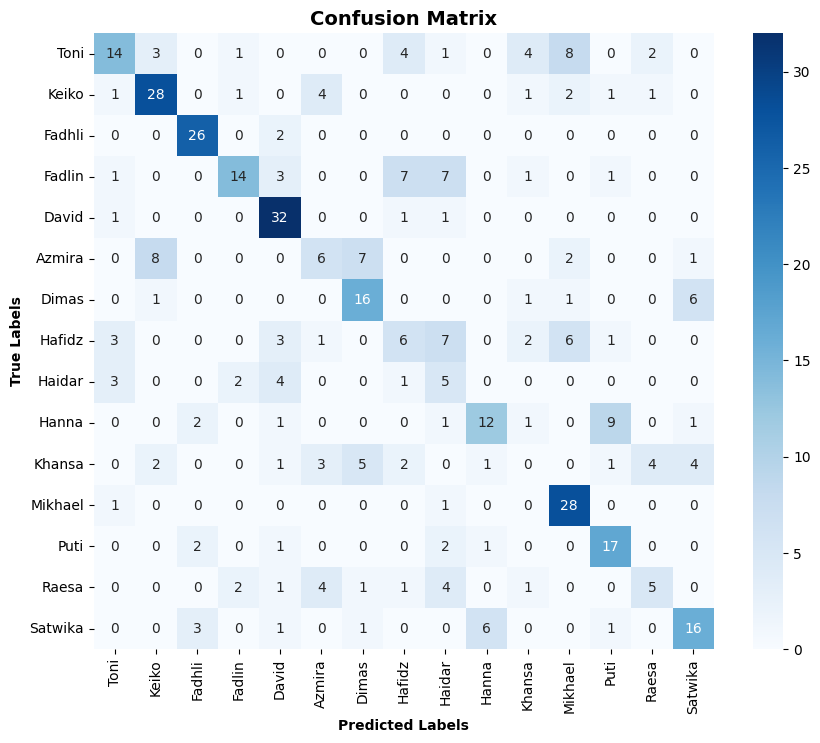

In [78]:
# Evaluasi model
y_preds = []
for x in X_test:
    _, _, _, y = feedForward(x, v, vb, w, wb)
    y_preds.append(np.argmax(y))  # Prediksi kelas berdasarkan output softmax

accuracy = accuracy_score(np.argmax(y_test, axis=1), y_preds)
print(f"Testing Accuracy: {accuracy:.2%}")

# berdasarkan flattend data
class_names = ["Toni", 'Keiko', 'Fadhli', 'Fadlin', 'David',
               'Azmira', 'Dimas', 'Hafidz', 'Haidar', 'Hanna',
               'Khansa', 'Mikhael', 'Puti', 'Raesa', 'Satwika']

# Visualisasi Confusion Matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels", weight = 'bold')
plt.ylabel("True Labels", weight = 'bold')
plt.title("Confusion Matrix", fontsize = 14, weight = 'bold')
plt.show()

#**CONCLUSION**
---
